In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader,Subset
import numpy as np
from torch import nn
import math
import torch.nn.functional as F
import torchvision.datasets as datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
data = datasets.CelebA(root="C:/Users/maddo/Downloads/COdes from Work/Working on now",split='train',target_type='attr',download=True,transform=transform)

Files already downloaded and verified


In [4]:
len(data)

162770

In [5]:
subset_dataset = Subset(data, range(2000))

In [6]:
train_loader=DataLoader(subset_dataset,batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


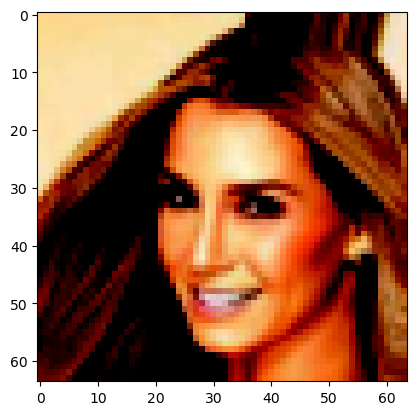

In [7]:
plt.imshow(data[0][0].permute(1, 2, 0))

In [118]:
beta = torch.linspace(0.003, 0.006, 300)
alpha = 1.0 - beta
alphacum = torch.cumprod(alpha, dim=0) 

In [9]:
sqrtalphacum.shape

torch.Size([300])

In [10]:
ind=0

In [11]:
def noisyimagetest(img,timestep,eps):
    mul=sqrtalphacum[timestep]
    epsmul=minsqrtalphacum[timestep]
    print(mul)
    mul = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    noisy=img*mul+eps*epsmul
    plt.subplot(4,1,1)
    plt.figsize=(10,19)
    plt.imshow(noisy[0].permute(1,2,0))
    plt.subplot(4,1,2)
    plt.imshow(noisy[1].permute(1,2,0))
    plt.subplot(4,1,3)
    plt.imshow(noisy[3].permute(1,2,0))
    plt.subplot(4,1,4)
    plt.imshow(noisy[4].permute(1,2,0))
    
    #return noisy
    

In [12]:
def noisyimage(img,timestep,eps):
    mul=sqrtalphacum[timestep]
    epsmul=minsqrtalphacum[timestep]
    mul = mul[:, None, None, None]
    epsmul = epsmul[:, None, None, None]
    noisy=img*mul+eps*epsmul
    return noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2074268..1.151599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1856099..0.85035145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2214963..1.0914876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2094458..1.161105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2074268..1.151599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1856099..0.85035145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2214963

tensor([0.9970, 0.9955, 0.9970, 0.9970, 0.9970, 0.9955, 0.9970, 0.9970, 0.9970,
        0.9970, 0.9970, 0.9955, 0.9970, 0.9955, 0.9955, 0.9970, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9970])
tensor([0.9970, 0.9955, 0.9970, 0.9970, 0.9970, 0.9955, 0.9970, 0.9970, 0.9970,
        0.9970, 0.9970, 0.9955, 0.9970, 0.9955, 0.9955, 0.9970, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9970])
tensor([0.9970, 0.9955, 0.9970, 0.9970, 0.9970, 0.9955, 0.9970, 0.9970, 0.9970,
        0.9970, 0.9970, 0.9955, 0.9970, 0.9955, 0.9955, 0.9970, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955, 0.9955,
        0.9955, 0.9970, 0.9955, 0.9955, 0.9970])


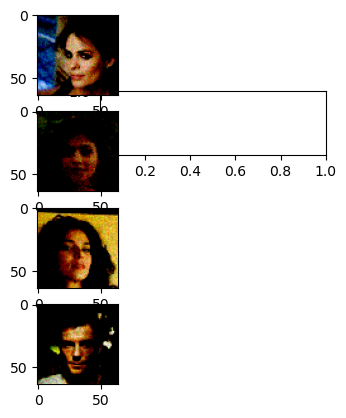

In [23]:
for x,_ in train_loader:
    times=torch.randint(1,3,(len(x),))
    eps=torch.randn_like(x)
    #print(eps.shape)
    plt.subplot(5,2,4)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    noisyimagetest(x,times,eps)
    break

In [24]:
def extract(a, t, x_shape):
    """
    Take a 1D tensor a of length T, pick entries at indices t (B,), and reshape for broadcast to x_shape.
    """
    b = t.shape[0]
    out = a.gather(0, t).reshape(b, *([1] * (len(x_shape) - 1)))
    return out

In [102]:
class noisepredict(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(3*64*64+1,200)
        self.fc2=nn.Linear(200,300)
        self.fc3=nn.Linear(300,3*64*64)
        self.relu=nn.ReLU()
    def forward(self,x,t):
        x=x.view(len(x),-1)
        t=t.view(len(x),1)
        x=torch.cat((x,t),axis=1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        return x.reshape(len(x),3,64,64)

In [103]:
enc=noisepredict()

In [104]:
criterion=nn.MSELoss()
optim=torch.optim.Adam(enc.parameters(),lr=1e-4)

In [105]:
ha=torch.randint(0,100,(64,))

In [106]:
ha

tensor([52, 68, 39, 78, 52, 42,  7, 31, 82, 71, 22, 96, 49, 54,  2, 23, 80, 95,
        34, 91, 56, 41, 43,  5, 81, 11, 72, 92, 22, 17, 76, 96, 47, 65,  3, 62,
        99, 68, 71, 53, 68, 40, 45,  2, 16, 92, 65, 85, 15, 22, 35, 77, 94,  9,
         4, 18, 77, 41, 49, 66, 40, 69, 16, 29])

In [107]:
epoch=50

In [110]:
for i in range(epoch):
    oneofus=0
    for x,_ in train_loader:
        times=torch.randint(1,299,(len(x),))
        eps=torch.randn(len(x),3,64,64)
        x_time=noisyimage(x,times,eps)
        pred=enc(x,times)
        optim.zero_grad()
        loss=criterion(pred,eps)
        #print(loss.item())
        loss.backward()
        optim.step()
        oneofus=loss.item()
    print(f"  Loss is currently {oneofus}")#
        
        

        
        
    

  Loss is currently 1.0009018182754517
  Loss is currently 0.9977245926856995


KeyboardInterrupt: 

In [134]:
def sample(model, x_t, t):
    # t should be (B,) long
    t = t.view(-1).long().to(x_t.device)

    # Gather scalars per batch and reshape to (B,1,1,1)
    alpha_t      = alpha[t].to(x_t.device).view(-1, 1, 1, 1)
    alpha_hat_t  = alphacum[t].to(x_t.device).view(-1, 1, 1, 1)
    beta_t       = beta[t].to(x_t.device).view(-1, 1, 1, 1)
    alpha_prev_t = alphacum[(t - 1).clamp(min=0)].to(x_t.device).view(-1, 1, 1, 1)

    eps = model(x_t, t)  # your 'enc' network; shape (B,3,64,64)

    # DDPM mean
    mean = (1.0 / torch.sqrt(alpha_t)) * (
        x_t - ((1.0 - alpha_t) / torch.sqrt(1.0 - alpha_hat_t)) * eps
    )

    # DDPM variance (use sqrt for sigma)
    var   = (1.0 - alpha_prev_t) / (1.0 - alpha_hat_t) * beta_t
    sigma = torch.sqrt(torch.clamp(var, min=1e-20))

    # Noise (optional: set z=0 when t==0)
    z = torch.randn_like(x_t)
    out = mean + sigma * z
    print(out.shape)   # -> (B, 3, 64, 64)
    plt.imshow(out[0].detach().permute(1,2,0))
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7143242..3.8420398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6083734..4.057757].


torch.Size([6, 3, 64, 64])
torch.Size([6, 3, 64, 64])


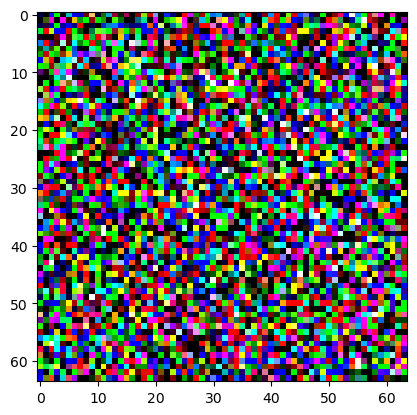

In [135]:
for _ in range(2):
    newsamples = torch.randn(6, 3, 64, 64)
    tsamples   = torch.full((newsamples.size(0),), 1, dtype=torch.long)  # (B,) long
    sample(enc, newsamples, tsamples)